In [86]:
import h5py
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torch.nn.utils import clip_grad_norm_
import torch.nn as nn
import tensorflow as tf
import torch.optim as optim
from torchvision.transforms import Resize
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import datasets, transforms
from torch.autograd import Variable
import math
import re

In [87]:

class HDF5Dataset_old(Dataset):
    def __init__(self, file_path, data_key):
        self.file_path = file_path
        self.data_key = data_key

        # Open the HDF5 file
        self.h5file = h5py.File(file_path, 'r')
        # Get the HDF5 dataset
        self.data = self.h5file[data_key][:]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
       
        image = self.data[index]
        
        image=image/image.max()
    
      
        return image

# Specify the path to the HDF5 file and the dataset key
file_path = '/home/ferroelectric/RHEED_paper/m3_learning/m3_learning/papers/2023_RHEED_PLD_SrTiO3/Datasets/test6_gaussian_fit_parameters_all-04232023.h5'
dataset_key = 'growth_1/spot_2/raw_image'



# Create an instance of the HDF5Dataset
# dataset = HDF5Dataset(file_path, dataset_key)

# Create a data loader for the dataset
# batch_size = 300
# data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)



# plt.imshow(dataset[0])
# print(dataset[0].shape)
# plt.colorbar()
# plt.show()



In [88]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch

class HDF5Dataset(Dataset):
    def __init__(self, file_path):
        self.file_path = file_path
        
        with h5py.File(file_path,'r') as h5:
            data = []
            growth_numbers = []

            # Iterate through the groups and match the pattern
            for key in h5.keys():
                match = re.match(r'growth_(\d+)', key)
                if match:
                    growth_number = int(match.group(1))
                    growth_numbers.append(growth_number)

                    # Extract the corresponding dataset
                    dataset = np.array(h5[key]["spot_2"])
                    data.append(dataset)
                    
            # Concatenate all the datasets and normalize
            data = np.vstack(data)
            
        self.data = data
       
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = (self.data[index]).astype(np.float32)
        image_max = np.max(image)
        image /= image_max
        return image, image_max

# Specify the path to the HDF5 file and the dataset key
file_path = '/home/ferroelectric/sean/RHEED_4848_test6.h5'
    

combined_dataset = HDF5Dataset(file_path)

# Create a data loader for the combined dataset
batch_size = 1000
data_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)




torch.Size([1000, 48, 48])
tensor(125.)


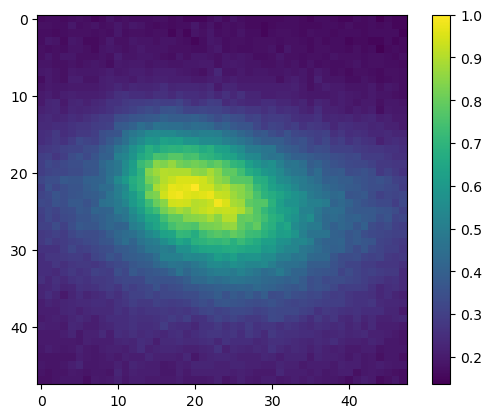

In [89]:
data, image_max = next(iter(data_loader))
print(data.shape)
plt.imshow(data[2])
plt.colorbar()
print(image_max[2])

In [174]:
import numpy as np
from scipy.optimize import least_squares
from dask import delayed, compute
from dask.distributed import Client
import h5py

# Defining the 2D Gaussian function
def gaussian2D(x_y, A, x0, y0, sigma_x, sigma_y):
    x, y = x_y
    return A * np.exp(-((x - x0)**2 / (2 * sigma_x**2) + (y - y0)**2 / (2 * sigma_y**2)))


# Computing residuals for least-squares minimization
def residuals(params, x, y, data):
    A, x0, y0, sigma_x, sigma_y = params
    model = gaussian2D((x, y), A, x0, y0, sigma_x, sigma_y)
    return (model - data).ravel()

def convert_parameters(parameters):
    A, x0, y0, sigma_x, sigma_y = parameters
    
    mean_x = x0
    mean_y = y0
    cov_x = sigma_x
    cov_y = sigma_y
    
    # Calculate theta from the covariance values
    if cov_x != 0 and cov_y != 0:
        theta = 0.5 * np.arctan(2 * cov_x * cov_y / (cov_x**2 - cov_y**2)+1e-9)
    else:
        theta = 0.0
    
    return mean_x, mean_y, cov_x, cov_y, theta

# Fitting multiple images using Dask
def fit_and_convert_parameters(h5_filename):
    all_converted_params = []  
    
    with h5py.File(h5_filename, 'r') as h5_file:
        for group_num in range(1, 13):  
            group_name = f'growth_{group_num}'
            if group_name in h5_file:
                group = h5_file[group_name]['spot_2']

                images = group[:]  
                
                normalized_images = [image / image.max() for image in images]  
                
                guesses = [add_guess(image) for image in normalized_images]
                fits = [fit_gaussian2D_delayed(image, guess) for image, guess in zip(normalized_images, guesses)]
                
                converted_params = [convert_parameters(params) for params in compute(*fits)]
                all_converted_params.extend(converted_params)  

    return all_converted_params, normalized_images


# Parallelizing the fit function using Dask's delayed
@delayed
def fit_gaussian2D_delayed(data, guess):
    y, x = np.indices(data.shape)
    result = least_squares(residuals, guess, args=(x, y, data),method='lm')#change method back for old results
    return result.x

# Adding an initial guess for the fit
def add_guess(data):
    A_guess = np.max(data)
    x0_guess, y0_guess = np.unravel_index(np.argmax(data), data.shape)
    sigma_x_guess = sigma_y_guess = np.std(data)
    return [A_guess, x0_guess, y0_guess, sigma_x_guess, sigma_y_guess]

# Main code
if __name__ == "__main__":
    h5_filename = "/home/ferroelectric/sean/RHEED_4848_test6.h5"  # Replace with the actual path
    
    with Client() as client:  # Starts a local cluster or connects to an existing one
        results2 ,images2= fit_and_convert_parameters(h5_filename)
    #I changed this to results2 when I added the "method" argument to the fit_gaussian2D_delayed method


/tmp/ipykernel_114617/3583421788.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  theta = 0.5 * np.arctan(2 * cov_x * cov_y / (cov_x**2 - cov_y**2)+1e-9)
2023-08-29 17:17:31,055 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/home/ferroelectric/micromamba/envs/hls/lib/python3.9/site-packages/distributed/comm/tcp.py", line 224, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ferroelectric/micromamba/envs/hls/lib/python3.9/site-packages/distributed/worker.py", line 1253, in heartbeat
    response = await retry_operation(
  File "/home/ferroelectric/micromamba/envs/hls/lib/python3.9/site-packages/distributed/utils_comm.py", line 454, in retry_operation
    return await retry(
  File "/home/ferroelectric/m

In [136]:
np.array(results).shape


(150985, 5)

In [137]:
from sklearn.preprocessing import StandardScaler
output_scaler = StandardScaler()
data=results #structed like [[meanx1,meany1,covx1,covy1,theta1],[meanx2,meany2,covx2,covy2,theta2]]
out_ = output_scaler.fit_transform(data)


(array([2.0000e+00, 1.0000e+01, 2.0000e+01, 1.0000e+00, 6.6130e+03,
        1.2390e+04, 2.3030e+04, 5.3464e+04, 4.9105e+04, 6.3500e+03]),
 array([-6.62317947, -5.73367572, -4.84417198, -3.95466823, -3.06516448,
        -2.17566074, -1.28615699, -0.39665324,  0.4928505 ,  1.38235425,
         2.271858  ]),
 <BarContainer object of 10 artists>)

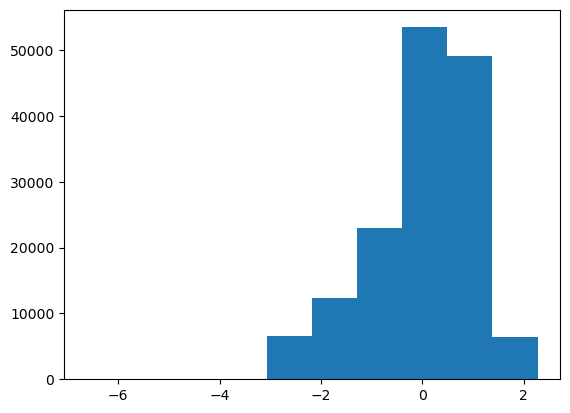

In [138]:
plt.hist(out_[:,0])


In [7]:
print(output_scaler.mean_)
print(output_scaler.var_)
print(output_scaler.inverse_transform(np.array([0.0270,  0.0296, -0.1340, -0.0099,  0.1330]).reshape(1, -1)))
unscaled_param1 = np.array([0.0270,  0.0296, -0.1340, -0.0099,  0.1330]) * (output_scaler.var_ ** 0.5) + (output_scaler.mean_)
print(unscaled_param1)

[22.47838205 24.4851125  16.8462797  12.07150492  0.62672398]
[5.46157544e+00 2.40898228e-01 9.97084168e+00 2.41086445e+00
 1.50743760e-03]
[[22.54148108 24.49964059 16.42315273 12.05613323  0.6318878 ]]
[22.54148108 24.49964059 16.42315273 12.05613323  0.6318878 ]


In [143]:
class LeNet5(nn.Module):
     def __init__(self,func,num_classes, testing=False):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 4, stride = 4))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(144, 98)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(98, 52)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(52, num_classes)
        self.func = func
        self.testing=testing
        self.flatten=nn.Flatten()

     def forward(self, x):
        x=x.float()
        out = self.layer1(x)
        out = self.layer2(out)

        out = self.flatten(out)
        
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        embedding = self.fc2(out)
        # print(f'before:{embedding[0]}')
        
    
      
        #need to use this, as output_scaler.inverse_transform() doesnt work with gradients/numpy conversions.  
        unscaled_param = embedding * torch.tensor(output_scaler.var_ ** 0.5).cuda() + torch.tensor(output_scaler.mean_).cuda()
        embedding[:,4]=(math.pi/4)*(nn.Tanh()(embedding[:,4]) + 1)
        # print(f'after:{unscaled_param[0]}')

        final = self.func(unscaled_param)
        
        
        if self.testing==True:
            return  embedding, unscaled_param, final 
        
        return final

    


In [144]:
class LeNet5_inference(nn.Module):
     def __init__(self,num_classes):
        super(LeNet5_inference, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 4, stride = 4))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(144, 72)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(72, 36)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(36, num_classes)
        

     def forward(self, x):
        x=x.float()
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        embedding = self.fc2(out)
        embedding=output_scaler.inverse_transform(embedding)
        
        return embedding

    


Generated Image Shape: torch.Size([1, 1, 48, 48])


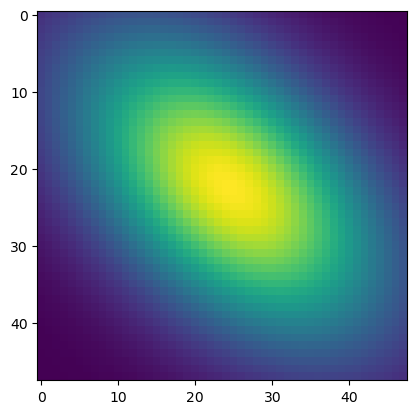

In [145]:
class GaussianGenerator(nn.Module):
    def __init__(self, img_dim):
        super(GaussianGenerator, self).__init__()
        self.img_dim = img_dim

    def forward(self, params):
        batch_size = params.shape[0]
        mean_x, mean_y, cov_x, cov_y, theta = params.unbind(dim=-1)
        cov_x = torch.clamp(cov_x, min=1e-9)
        cov_y = torch.clamp(cov_y, min=1e-9)

        x = torch.arange(self.img_dim[1], dtype=torch.float32).reshape(-1, 1).repeat(1, self.img_dim[0]).to(params.device)
        y = torch.arange(self.img_dim[0], dtype=torch.float32).reshape(1, -1).repeat(self.img_dim[1], 1).to(params.device)

        x = x.repeat(batch_size, 1, 1)
        y = y.repeat(batch_size, 1, 1)
        
        rota_matrix = torch.stack([torch.cos(theta), -torch.sin(theta), torch.sin(theta), torch.cos(theta)], dim=-1)
        rota_matrix = rota_matrix.view(batch_size, 2, 2)
        
        xy = torch.stack([x - mean_x.view(-1, 1, 1), y - mean_y.view(-1, 1, 1)], dim=-1)
        xy = torch.einsum('bijk,bkl->bijl', xy, rota_matrix)

        img = torch.exp(-0.5 * (xy[:, :, :, 0]**2 / (cov_x.view(-1, 1, 1)**2 ) + xy[:, :, :, 1]**2 / (cov_y.view(-1, 1, 1)**2 )))

        return img.unsqueeze(1)
    
    
img_dim = (48, 48)  # Replace with the desired image dimensions
model = GaussianGenerator(img_dim)
sample_params = torch.tensor([22.47838205, 24.4851125,  16.8462797,  10.07150492,  0.8], dtype=torch.float32)

# Reshape the sample_params tensor to have a batch dimension
sample_params_batched = sample_params.unsqueeze(0)
# Call the model to generate the Gaussian image
generated_img = model(sample_params_batched)


# Display the generated image shape
print("Generated Image Shape:", generated_img.shape)
plt.imshow(generated_img.squeeze(0).squeeze(0))

In [133]:
def custom_peak_sensitive_loss(y_true, y_pred):
    alpha = 1.0
    beta = 2.0
    gamma = 0.5
    epsilon = 1e-7

    # Log likelihood terms
    pos_log_likelihood = y_true * torch.log(y_pred + epsilon)
    neg_log_likelihood = (1 - y_true) * torch.log(1 - y_pred + epsilon)

    laplacian_kernel = torch.tensor([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).cuda()

    # Compute the Laplacian using convolution
    laplacian = F.conv2d(y_pred, laplacian_kernel, padding=1).cuda()

    loss = alpha * torch.sum(pos_log_likelihood) + beta * torch.sum(neg_log_likelihood) - gamma * torch.sum(laplacian)

    return -loss  # Minimizing negative of this loss is same as maximizing it


In [146]:
def custom_weighted_mse_loss(I, J, n):
    """
    Compute the custom weighted MSE loss between two grayscale images I and J.

    Parameters:
    - I: torch.Tensor of shape [batch_size, 1, M, N], the input image
    - J: torch.Tensor of shape [batch_size, 1, M, N], the target image
    - n: int, the exponent to raise the input image for the weight

    Returns:
    - loss: torch.Tensor, the computed loss
    """
    # Compute the weight
    W = torch.pow(I, n)

    # Compute the squared differences
    squared_diffs = torch.pow(I - J, 2)

    # Compute the weighted squared differences
    weighted_squared_diffs = W * squared_diffs

    # Compute the loss
    loss = torch.mean(weighted_squared_diffs)

    return loss

 

# Test the function
I = torch.randn(16, 1, 128, 128)  # Batch of 16 128x128 grayscale images
J = torch.randn(16, 1, 128, 128)  # Batch of 16 128x128 grayscale images
n = 2  # Exponent value

 

loss = custom_weighted_mse_loss(I, J, n)
print("Custom Weighted MSE Loss:", loss.item())

Custom Weighted MSE Loss: 4.058715343475342


In [163]:
#TRAINING LOOP


net = LeNet5(GaussianGenerator((48,48)).float(),5,testing=True).cuda().float() 
criterion = nn.MSELoss()


best_loss = float('inf')
# best_model_path = 'best-model.pt'

num_epochs = 100
lr=1e-6



optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=num_epochs, max_lr=1e-3, steps_per_epoch=len(data_loader))

n=1
scaled_tensors = []
unscaled_tensors = []
from tqdm import tqdm

for epoch in range(num_epochs):
    running_loss = 0.0
    
    if epoch%10 ==0:
        n+=0.1
        print(n)

    for i, (images, image_max) in enumerate(tqdm(data_loader)):
        
        images = images.unsqueeze(1)
        # images = output_scaler.transform(images)
        optimizer.zero_grad()
        scaled,unscaled, outputs = net(images.cuda())

        # loss = criterion(images.cuda().float(), outputs.float())  
        loss=custom_weighted_mse_loss(images.cuda().float(), outputs.float(), n)
        # loss = custom_peak_sensitive_loss(images.cuda().float(), outputs.float())  
        loss.backward()
        clip_grad_norm_(net.parameters(), 1)

        optimizer.step()
        scheduler.step()
        
        # if epoch>90:
        #     scaled_tensors.append(scaled.detach().cpu().numpy())
        #     unscaled_tensors.append(unscaled.detach().cpu().numpy())
            
        running_loss += loss.item()
    average_loss = running_loss / len(data_loader)
        

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}")
    
    # if average_loss < best_loss:
    #     best_loss = average_loss
    #     # Save the current model
    #     torch.save(net.state_dict(), best_model_path)



1.1


  0%|          | 0/151 [00:00<?, ?it/s]

100%|██████████| 151/151 [00:06<00:00, 22.88it/s]


Epoch [1/100], Loss: 0.011441239680083383


100%|██████████| 151/151 [00:06<00:00, 22.97it/s]


Epoch [2/100], Loss: 0.007598208621242978


100%|██████████| 151/151 [00:06<00:00, 21.89it/s]


Epoch [3/100], Loss: 0.006312595631014432


100%|██████████| 151/151 [00:06<00:00, 22.90it/s]


Epoch [4/100], Loss: 0.005192898833717139


100%|██████████| 151/151 [00:06<00:00, 22.88it/s]


Epoch [5/100], Loss: 0.004362397793285696


100%|██████████| 151/151 [00:06<00:00, 22.89it/s]


Epoch [6/100], Loss: 0.0036542012128016805


100%|██████████| 151/151 [00:06<00:00, 22.86it/s]


Epoch [7/100], Loss: 0.0034027778025445166


100%|██████████| 151/151 [00:06<00:00, 22.82it/s]


Epoch [8/100], Loss: 0.0033652627661774886


100%|██████████| 151/151 [00:06<00:00, 22.80it/s]


Epoch [9/100], Loss: 0.0033505608540472407


100%|██████████| 151/151 [00:06<00:00, 22.83it/s]


Epoch [10/100], Loss: 0.003342135999018684
1.2000000000000002


100%|██████████| 151/151 [00:06<00:00, 22.86it/s]


Epoch [11/100], Loss: 0.0030048933968762096


100%|██████████| 151/151 [00:06<00:00, 22.77it/s]


Epoch [12/100], Loss: 0.0030050292651212177


100%|██████████| 151/151 [00:06<00:00, 22.79it/s]


Epoch [13/100], Loss: 0.0030026906663366895


100%|██████████| 151/151 [00:06<00:00, 22.82it/s]


Epoch [14/100], Loss: 0.003001388751389767


100%|██████████| 151/151 [00:06<00:00, 21.74it/s]


Epoch [15/100], Loss: 0.0029974381827952844


100%|██████████| 151/151 [00:06<00:00, 22.77it/s]


Epoch [16/100], Loss: 0.002995938415768624


100%|██████████| 151/151 [00:06<00:00, 22.72it/s]


Epoch [17/100], Loss: 0.0029999752072555736


100%|██████████| 151/151 [00:06<00:00, 22.70it/s]


Epoch [18/100], Loss: 0.0029972060367662386


100%|██████████| 151/151 [00:06<00:00, 22.50it/s]


Epoch [19/100], Loss: 0.0029924801220833665


100%|██████████| 151/151 [00:06<00:00, 22.58it/s]


Epoch [20/100], Loss: 0.0029963137742304645
1.3000000000000003


100%|██████████| 151/151 [00:06<00:00, 22.59it/s]


Epoch [21/100], Loss: 0.002697671816024362


100%|██████████| 151/151 [00:06<00:00, 22.53it/s]


Epoch [22/100], Loss: 0.00270012758721579


100%|██████████| 151/151 [00:06<00:00, 22.53it/s]


Epoch [23/100], Loss: 0.002700718588485623


100%|██████████| 151/151 [00:06<00:00, 22.63it/s]


Epoch [24/100], Loss: 0.0026987568592492317


100%|██████████| 151/151 [00:06<00:00, 22.62it/s]


Epoch [25/100], Loss: 0.002698339085520202


100%|██████████| 151/151 [00:06<00:00, 22.68it/s]


Epoch [26/100], Loss: 0.0026969587174398416


100%|██████████| 151/151 [00:06<00:00, 21.71it/s]


Epoch [27/100], Loss: 0.00269905450007576


100%|██████████| 151/151 [00:06<00:00, 22.75it/s]


Epoch [28/100], Loss: 0.00269983036425088


100%|██████████| 151/151 [00:06<00:00, 22.76it/s]


Epoch [29/100], Loss: 0.0026984072463056502


100%|██████████| 151/151 [00:06<00:00, 22.69it/s]


Epoch [30/100], Loss: 0.0026980882852850174
1.4000000000000004


100%|██████████| 151/151 [00:06<00:00, 22.63it/s]


Epoch [31/100], Loss: 0.002438016798630949


100%|██████████| 151/151 [00:06<00:00, 22.64it/s]


Epoch [32/100], Loss: 0.0024349226628658394


100%|██████████| 151/151 [00:06<00:00, 22.62it/s]


Epoch [33/100], Loss: 0.0024346984253690537


100%|██████████| 151/151 [00:06<00:00, 22.64it/s]


Epoch [34/100], Loss: 0.0024353551912732075


100%|██████████| 151/151 [00:06<00:00, 22.64it/s]


Epoch [35/100], Loss: 0.0024340535939627924


100%|██████████| 151/151 [00:06<00:00, 22.67it/s]


Epoch [36/100], Loss: 0.0024342057618947813


100%|██████████| 151/151 [00:06<00:00, 22.63it/s]


Epoch [37/100], Loss: 0.002433951080634894


100%|██████████| 151/151 [00:06<00:00, 22.50it/s]


Epoch [38/100], Loss: 0.002434200132327364


100%|██████████| 151/151 [00:07<00:00, 21.49it/s]


Epoch [39/100], Loss: 0.002434839156844857


100%|██████████| 151/151 [00:06<00:00, 22.59it/s]


Epoch [40/100], Loss: 0.0024337147220673152
1.5000000000000004


100%|██████████| 151/151 [00:06<00:00, 22.60it/s]


Epoch [41/100], Loss: 0.0022013801449157345


100%|██████████| 151/151 [00:06<00:00, 22.60it/s]


Epoch [42/100], Loss: 0.002199128894628772


100%|██████████| 151/151 [00:06<00:00, 22.52it/s]


Epoch [43/100], Loss: 0.0021994650558204644


100%|██████████| 151/151 [00:06<00:00, 22.53it/s]


Epoch [44/100], Loss: 0.002198732616873273


100%|██████████| 151/151 [00:06<00:00, 22.48it/s]


Epoch [45/100], Loss: 0.0021998000004334957


100%|██████████| 151/151 [00:06<00:00, 22.62it/s]


Epoch [46/100], Loss: 0.0021994496134436683


100%|██████████| 151/151 [00:06<00:00, 22.56it/s]


Epoch [47/100], Loss: 0.002198931904484993


100%|██████████| 151/151 [00:06<00:00, 22.58it/s]


Epoch [48/100], Loss: 0.0021994344794518308


100%|██████████| 151/151 [00:06<00:00, 22.63it/s]


Epoch [49/100], Loss: 0.002198886409993993


100%|██████████| 151/151 [00:06<00:00, 21.61it/s]


Epoch [50/100], Loss: 0.0021995544920841983
1.6000000000000005


100%|██████████| 151/151 [00:06<00:00, 22.64it/s]


Epoch [51/100], Loss: 0.0019907238577116307


100%|██████████| 151/151 [00:06<00:00, 22.67it/s]


Epoch [52/100], Loss: 0.0019910188387178922


100%|██████████| 151/151 [00:06<00:00, 22.60it/s]


Epoch [53/100], Loss: 0.001990731564251743


100%|██████████| 151/151 [00:06<00:00, 22.61it/s]


Epoch [54/100], Loss: 0.0019899665544561994


100%|██████████| 151/151 [00:06<00:00, 22.60it/s]


Epoch [55/100], Loss: 0.0019897537827121697


100%|██████████| 151/151 [00:06<00:00, 22.57it/s]


Epoch [56/100], Loss: 0.0019900269979080615


100%|██████████| 151/151 [00:06<00:00, 22.56it/s]


Epoch [57/100], Loss: 0.0019892580238238767


100%|██████████| 151/151 [00:06<00:00, 22.58it/s]


Epoch [58/100], Loss: 0.0019886779193365517


100%|██████████| 151/151 [00:06<00:00, 22.59it/s]


Epoch [59/100], Loss: 0.0019895072158315026


100%|██████████| 151/151 [00:06<00:00, 22.54it/s]


Epoch [60/100], Loss: 0.001989135734539553
1.7000000000000006


100%|██████████| 151/151 [00:06<00:00, 22.49it/s]


Epoch [61/100], Loss: 0.0018025548783260465


100%|██████████| 151/151 [00:07<00:00, 21.54it/s]


Epoch [62/100], Loss: 0.0018024756927783323


100%|██████████| 151/151 [00:06<00:00, 22.57it/s]


Epoch [63/100], Loss: 0.0018026247622124506


100%|██████████| 151/151 [00:06<00:00, 22.68it/s]


Epoch [64/100], Loss: 0.0018027362688167008


100%|██████████| 151/151 [00:06<00:00, 22.72it/s]


Epoch [65/100], Loss: 0.0018013654545023545


100%|██████████| 151/151 [00:06<00:00, 22.66it/s]


Epoch [66/100], Loss: 0.0018016637321438221


100%|██████████| 151/151 [00:06<00:00, 22.64it/s]


Epoch [67/100], Loss: 0.0018020365209879957


100%|██████████| 151/151 [00:06<00:00, 22.62it/s]


Epoch [68/100], Loss: 0.001802038770656268


100%|██████████| 151/151 [00:06<00:00, 22.58it/s]


Epoch [69/100], Loss: 0.0018027724708979394


100%|██████████| 151/151 [00:06<00:00, 22.57it/s]


Epoch [70/100], Loss: 0.0018014607392868262
1.8000000000000007


100%|██████████| 151/151 [00:06<00:00, 22.61it/s]


Epoch [71/100], Loss: 0.001634620184029471


100%|██████████| 151/151 [00:06<00:00, 22.55it/s]


Epoch [72/100], Loss: 0.0016350762676509308


100%|██████████| 151/151 [00:06<00:00, 22.66it/s]


Epoch [73/100], Loss: 0.0016343151897636075


100%|██████████| 151/151 [00:06<00:00, 21.64it/s]


Epoch [74/100], Loss: 0.0016343739463497472


100%|██████████| 151/151 [00:06<00:00, 22.71it/s]


Epoch [75/100], Loss: 0.0016339653516990065


100%|██████████| 151/151 [00:06<00:00, 22.59it/s]


Epoch [76/100], Loss: 0.0016343184301185589


100%|██████████| 151/151 [00:06<00:00, 22.65it/s]


Epoch [77/100], Loss: 0.0016339862332155077


100%|██████████| 151/151 [00:06<00:00, 22.66it/s]


Epoch [78/100], Loss: 0.0016339013340654753


100%|██████████| 151/151 [00:06<00:00, 22.61it/s]


Epoch [79/100], Loss: 0.0016337922274671643


100%|██████████| 151/151 [00:06<00:00, 22.48it/s]


Epoch [80/100], Loss: 0.001633740108867256
1.9000000000000008


100%|██████████| 151/151 [00:06<00:00, 22.47it/s]


Epoch [81/100], Loss: 0.0014836910675705367


100%|██████████| 151/151 [00:06<00:00, 22.62it/s]


Epoch [82/100], Loss: 0.0014837879505600559


100%|██████████| 151/151 [00:06<00:00, 22.49it/s]


Epoch [83/100], Loss: 0.0014837418323604772


100%|██████████| 151/151 [00:06<00:00, 22.51it/s]


Epoch [84/100], Loss: 0.0014839081613297594


100%|██████████| 151/151 [00:06<00:00, 22.59it/s]


Epoch [85/100], Loss: 0.0014836406982843054


100%|██████████| 151/151 [00:07<00:00, 21.57it/s]


Epoch [86/100], Loss: 0.0014836472846160562


100%|██████████| 151/151 [00:06<00:00, 22.57it/s]


Epoch [87/100], Loss: 0.0014834866330138599


100%|██████████| 151/151 [00:06<00:00, 22.56it/s]


Epoch [88/100], Loss: 0.0014837433442177362


100%|██████████| 151/151 [00:06<00:00, 22.50it/s]


Epoch [89/100], Loss: 0.0014836228659240813


100%|██████████| 151/151 [00:06<00:00, 22.58it/s]


Epoch [90/100], Loss: 0.0014835939879856066
2.000000000000001


100%|██████████| 151/151 [00:06<00:00, 22.61it/s]


Epoch [91/100], Loss: 0.0013490163178386673


100%|██████████| 151/151 [00:06<00:00, 22.64it/s]


Epoch [92/100], Loss: 0.0013488417796617904


100%|██████████| 151/151 [00:06<00:00, 22.53it/s]


Epoch [93/100], Loss: 0.0013487814094513557


100%|██████████| 151/151 [00:06<00:00, 22.59it/s]


Epoch [94/100], Loss: 0.0013489063963331035


100%|██████████| 151/151 [00:06<00:00, 22.57it/s]


Epoch [95/100], Loss: 0.0013488388037469412


100%|██████████| 151/151 [00:06<00:00, 22.69it/s]


Epoch [96/100], Loss: 0.0013487712466250489


100%|██████████| 151/151 [00:06<00:00, 21.67it/s]


Epoch [97/100], Loss: 0.0013488054195332606


100%|██████████| 151/151 [00:06<00:00, 22.63it/s]


Epoch [98/100], Loss: 0.0013487675521732462


100%|██████████| 151/151 [00:06<00:00, 22.50it/s]


Epoch [99/100], Loss: 0.0013487399447808005


100%|██████████| 151/151 [00:06<00:00, 22.66it/s]

Epoch [100/100], Loss: 0.0013488100954201936


1358865
0.6143915
(1358865, 5)
mean is [0.728266, -4.6289816, -1.4548855, 0.7148189, 1.5707221]
std is [0.22154126, 4.433015, 0.96062917, 0.66558856, 0.007582712]
-0.61401206
1.622214
-0.6143802
3.0410657


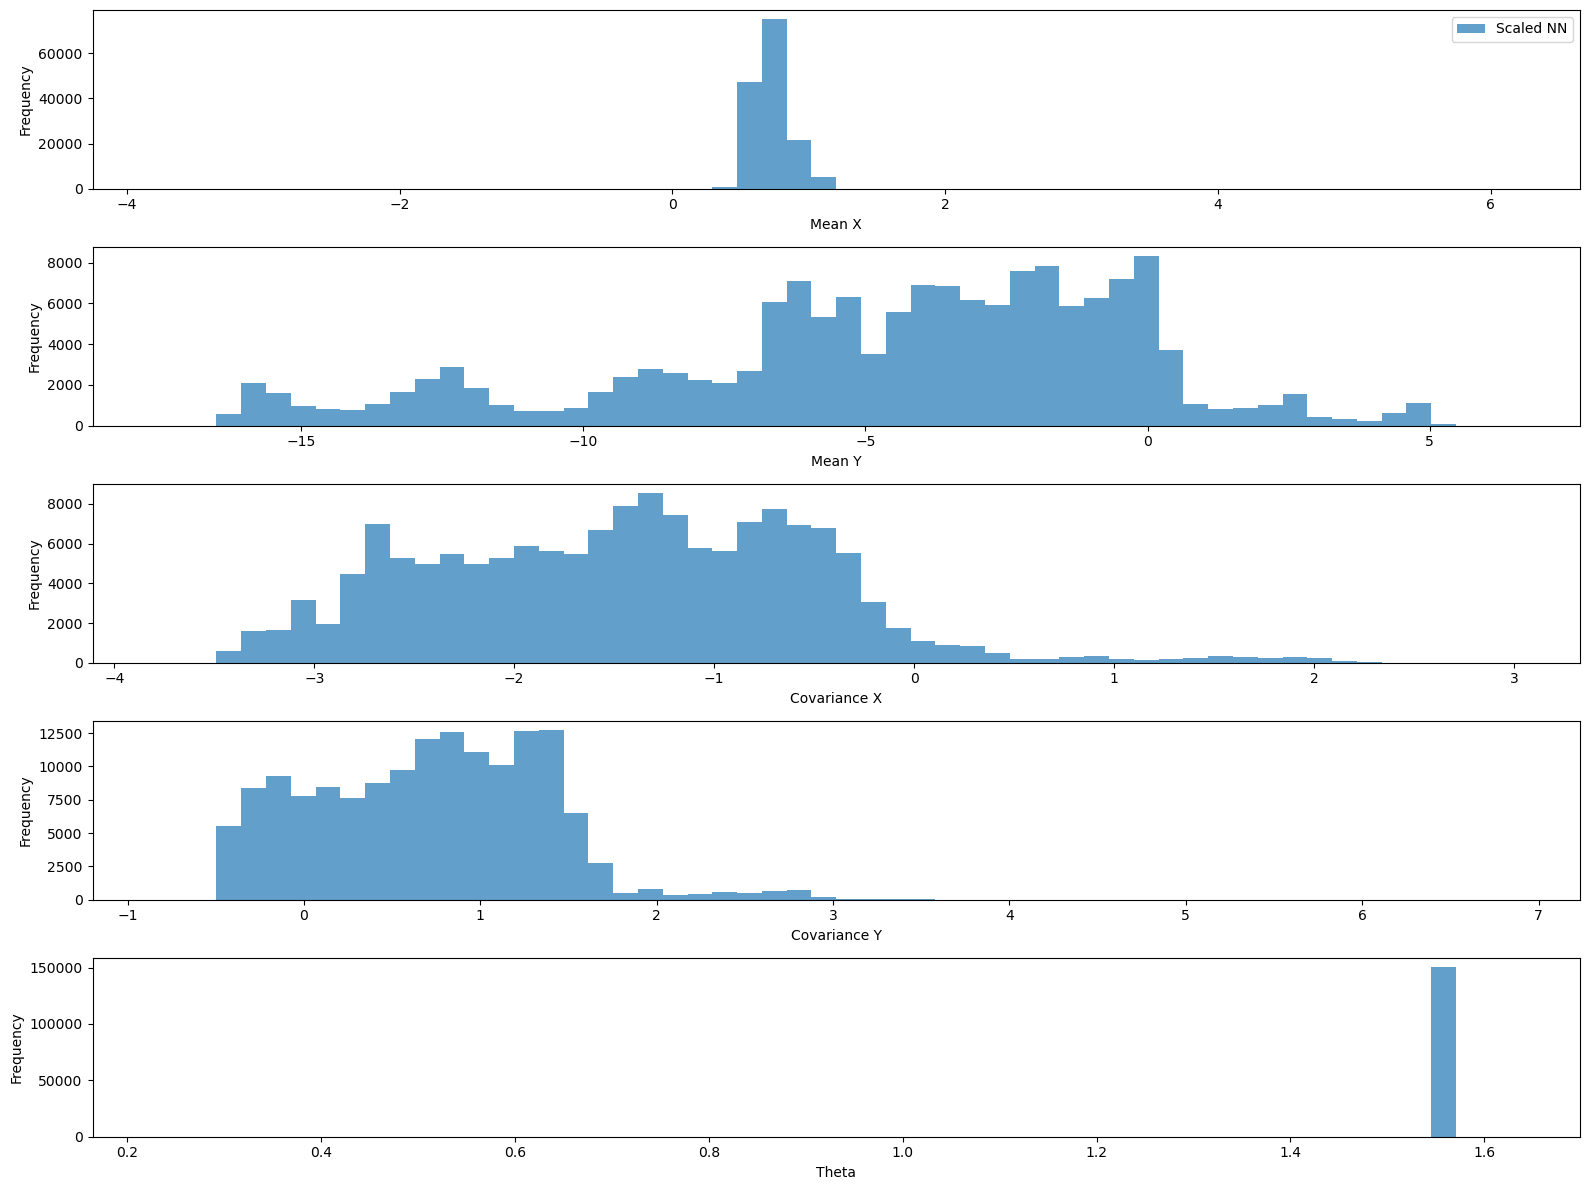

In [128]:

scaled_values = np.array((np.concatenate(scaled_tensors)))
print(len(scaled_values))
print(scaled_values[1][0])
unscaled_values = np.array((np.concatenate(unscaled_tensors)))
print(unscaled_values.shape)

LSQF_meanx=[]
LSQF_meany=[]
LSQF_covx=[]
LSQF_covy=[]
LSQF_theta=[]
unscaled_meanx=[]
unscaled_meany=[]
unscaled_covx=[]
unscaled_covy=[]
unscaled_theta=[]
scaled_meanx=[]
scaled_meany=[]
scaled_covx=[]
scaled_covy=[]
scaled_theta=[]

for idx in range(150984):
    LSQF_meanx.append(LSQF[idx][0])
    LSQF_meany.append(LSQF[idx][1])
    LSQF_covx.append(LSQF[idx][2])
    LSQF_covy.append(LSQF[idx][3])
    LSQF_theta.append(LSQF[idx][4])
    unscaled_meanx.append(unscaled_values[idx][0])
    unscaled_meany.append(unscaled_values[idx][1])
    unscaled_covx.append(unscaled_values[idx][2])
    unscaled_covy.append(unscaled_values[idx][3])
    unscaled_theta.append(unscaled_values[idx][4])
    scaled_meanx.append(scaled_values[idx][0])
    scaled_meany.append(scaled_values[idx][1])
    scaled_covx.append(scaled_values[idx][2])
    scaled_covy.append(scaled_values[idx][3])
    scaled_theta.append(scaled_values[idx][4])

print(f'mean is {[np.mean(scaled_meanx),np.mean(scaled_meany),np.mean(scaled_covx),np.mean(scaled_covy),np.mean(scaled_theta)]}')
print(f'std is {[np.std(scaled_meanx),np.std(scaled_meany),np.std(scaled_covx),np.std(scaled_covy),np.std(scaled_theta)]}')
print(np.mean([np.mean(scaled_meanx),np.mean(scaled_meany),np.mean(scaled_covx),np.mean(scaled_covy),np.mean(scaled_theta)]))
print(np.std([np.std(scaled_meanx),np.std(scaled_meany),np.std(scaled_covx),np.std(scaled_covy),np.std(scaled_theta)]))
print(np.mean(scaled_values))
print(np.std(scaled_values))

fig, axs = plt.subplots(5, 1, figsize=(16, 12))
axs = axs.flatten()

def calculate_x_limits(data):
    data_min = min(data)
    data_max = max(data)
    margin = (data_max - data_min) * 0.1  # Add a 10% margin on both sides
    x_min = data_min - margin
    x_max = data_max + margin
    return x_min, x_max


# Create histograms for 'scaled' and 'unscaled'
data_labels = [
    ('Mean X', LSQF_meanx, unscaled_meanx, scaled_meanx,50,20,20),
    ('Mean Y', LSQF_meany, unscaled_meany, scaled_meany,70,10,20),
    ('Covariance X', LSQF_covx, unscaled_covx, scaled_covx,70,20,20),
    ('Covariance Y', LSQF_covy, unscaled_covy, scaled_covy,70,20,20),
    ('Theta', LSQF_theta, unscaled_theta, scaled_theta,70,10,30)
]


for ax_idx, (label, lsqf_data, unscaled_data, scaled_data,bins1,bins2,bins3) in enumerate(data_labels):
    # Calculate x-limits based on data
    lsqf_x_min, lsqf_x_max = calculate_x_limits(scaled_data)
    unscaled_x_min, unscaled_x_max = calculate_x_limits(scaled_data)
    scaled_x_min, scaled_x_max = calculate_x_limits(scaled_data)
    x_min = min(lsqf_x_min, unscaled_x_min, scaled_x_min)
    x_max = max(lsqf_x_max, unscaled_x_max, scaled_x_max)
    
    # Create histograms for LSQF, unscaled, and scaled data
    ax = axs[ax_idx]
    # ax.hist(lsqf_data, label='LSQF', bins=bins1)
    # ax.hist(unscaled_data, label='Unscaled NN', alpha=0.7, bins=bins2)  # Adjust alpha for visibility
    ax.hist(scaled_data, label='Scaled NN', alpha=0.7, bins=50)  # Adjust alpha for visibility
    
    # Set x-limits and labels
    ax.set_xlim(x_min, x_max)
    ax.set_xlabel(label)
    ax.set_ylabel('Frequency')
    
    # Add legend to the first subplot
    if ax_idx == 0:
        ax.legend()

plt.tight_layout()
plt.show()









In [164]:
with torch.no_grad():
  dev=torch.device("cuda")
  data, image_max = next(iter(data_loader))
  data=data.unsqueeze(1)
  data_ = data.cpu()
  optimizer.zero_grad()
  scaled, unscaled, outputs = net(data.to('cuda'))
  
  

In [176]:
manual_im=[]
manual_im_matched=[]

for i in range(100):
    manual_im.append(gaussian((48,48),results2[i]))
    manual_im_matched.append(images2[i])
    
print(np.array(manual_im).shape)


(100, 48, 48)


In [167]:
def gaussian(img_dim,params):
    params=np.array(params)
    mean_x, mean_y, cov_x, cov_y, theta = params
    
    x = np.arange(img_dim[1], dtype=np.float32)
    y = np.arange(img_dim[0], dtype=np.float32)
    x, y = np.meshgrid(x, y)

    x = np.expand_dims(x, axis=0)
    y = np.expand_dims(y, axis=0)

    x = np.repeat(x, 1, axis=0)
    y = np.repeat(y, 1, axis=0)

    rota_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    rota_matrix = np.reshape(rota_matrix, (1, 2, 2))

    xy = np.stack([x - mean_x, y - mean_y], axis=-1)
    xy = np.einsum('bijk,bkl->bijl', xy, rota_matrix)

    img = np.exp(-0.5 * (xy[:, :, :, 0]**2 / (cov_x**2) + xy[:, :, :, 1]**2 / (cov_y**2)))
    return img[0,:,:]



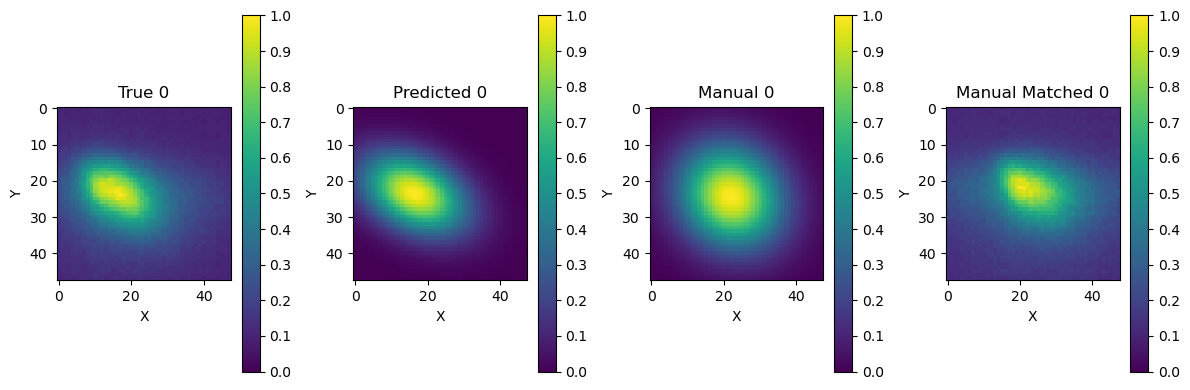

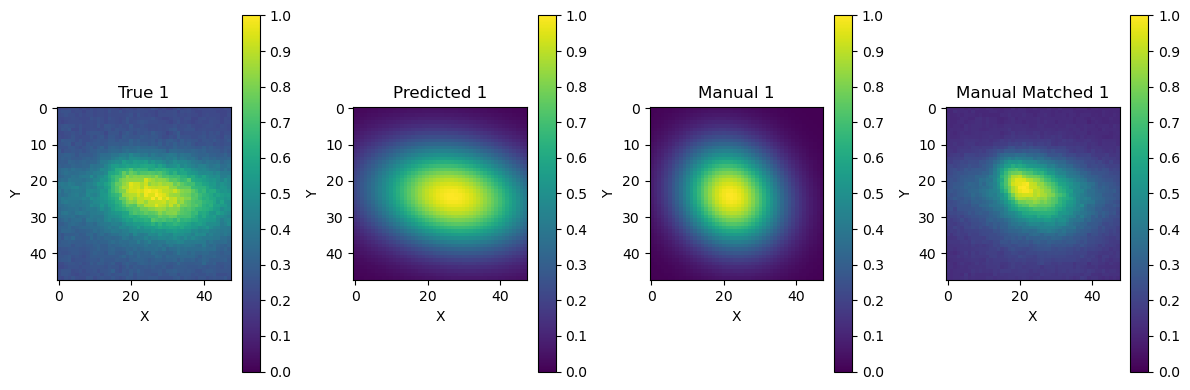

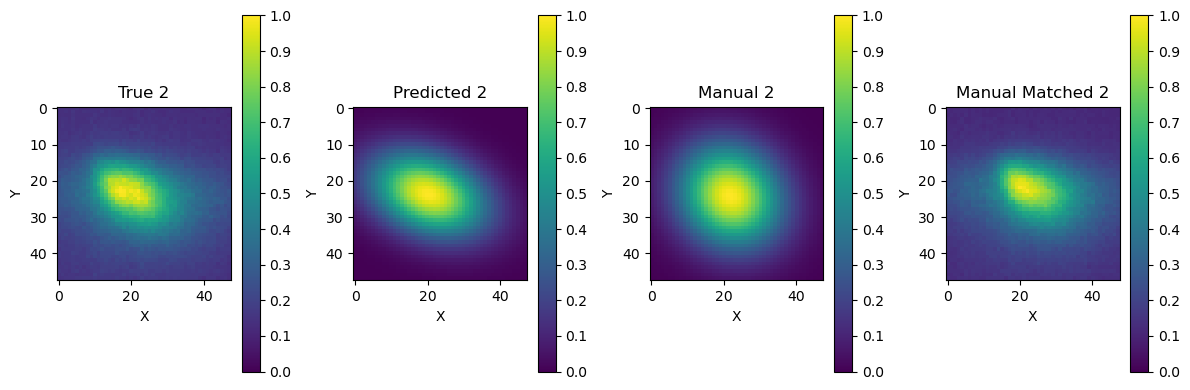

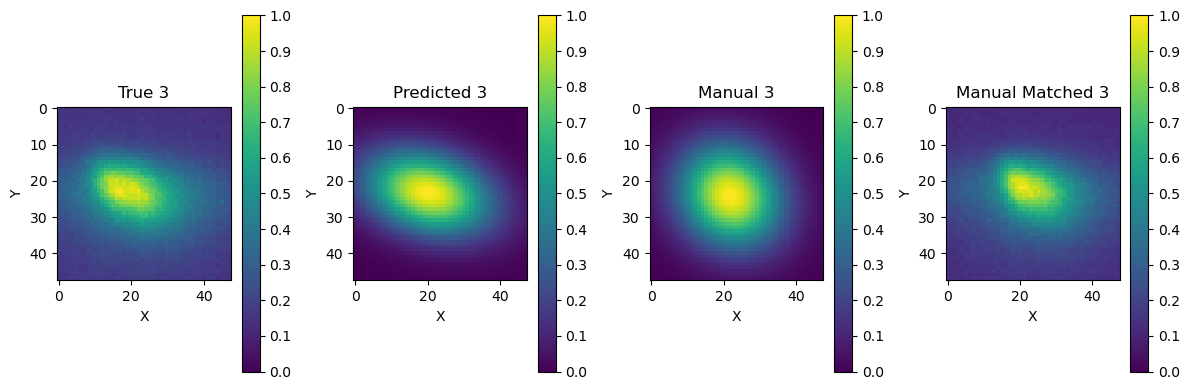

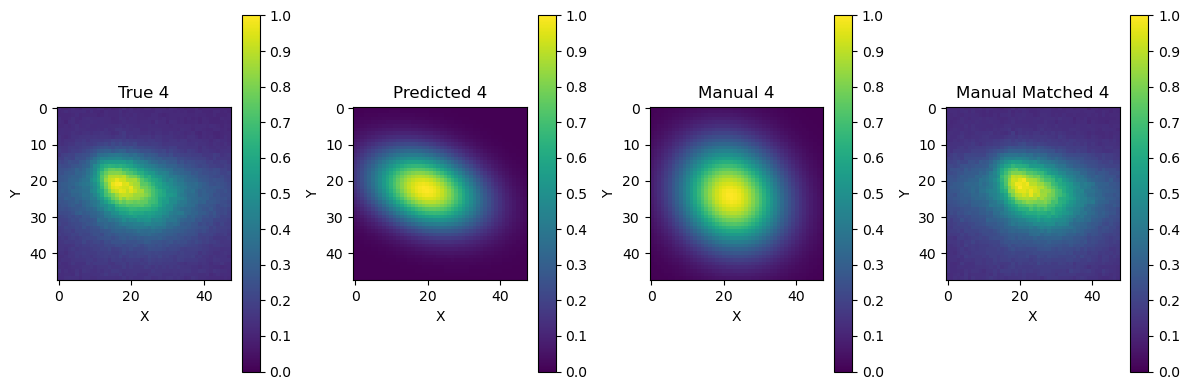

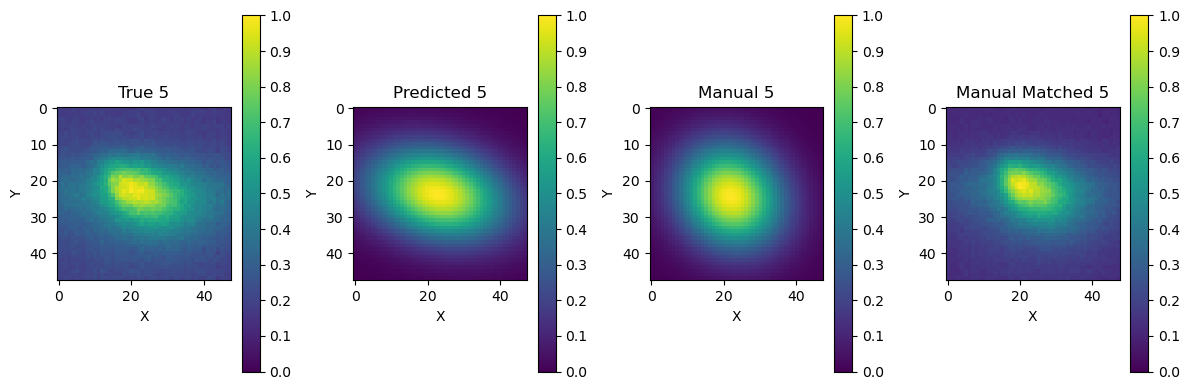

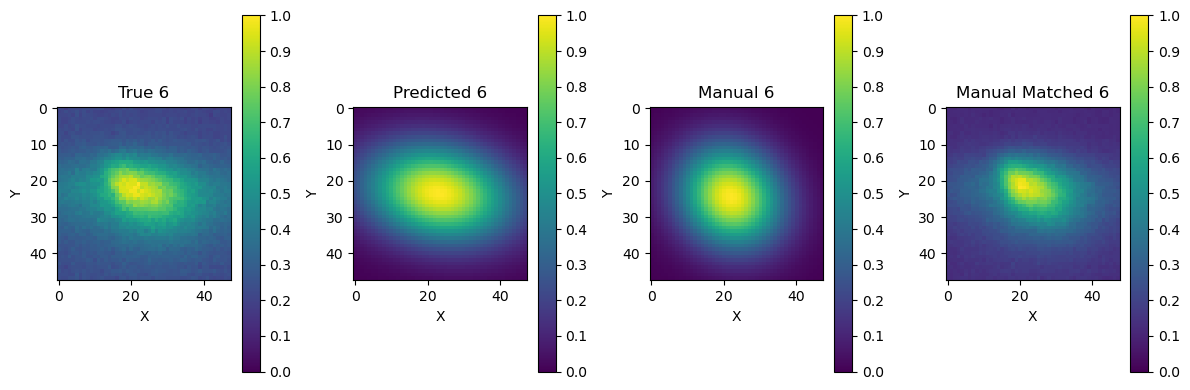

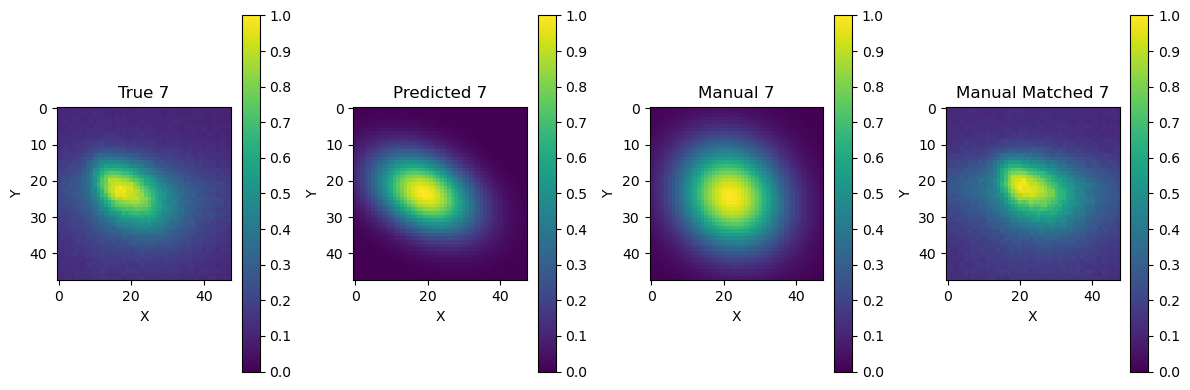

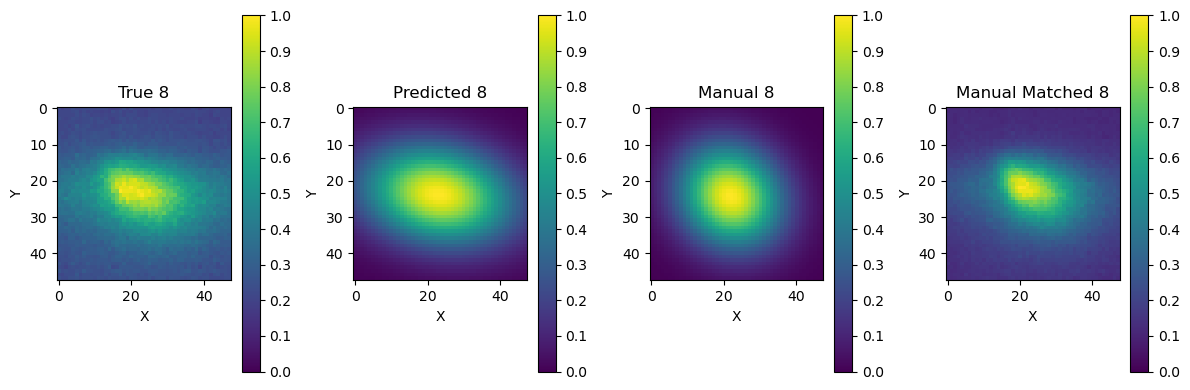

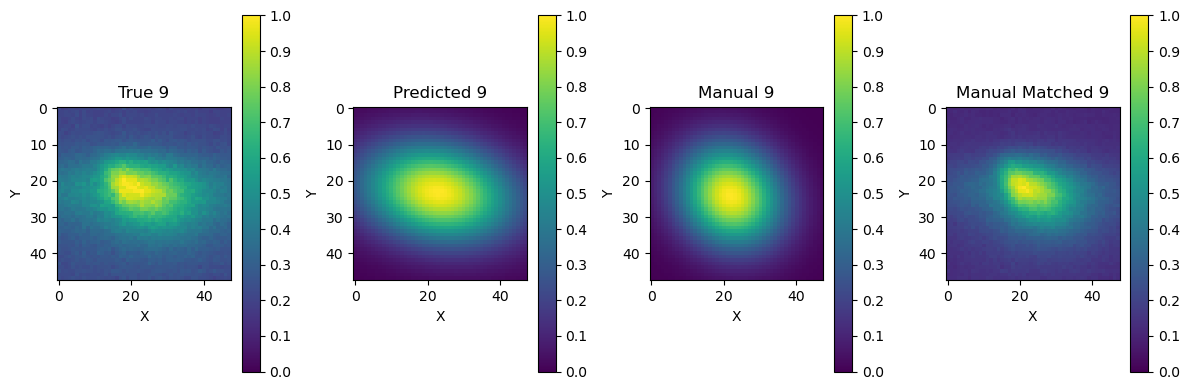

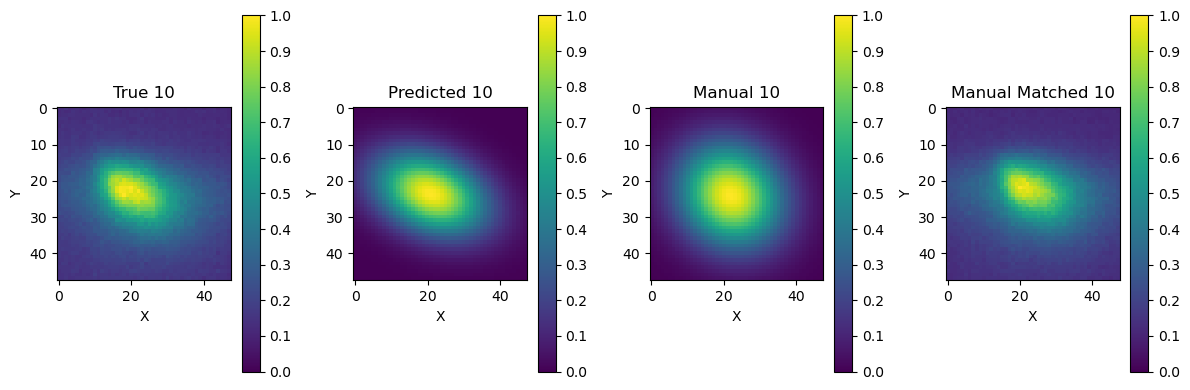

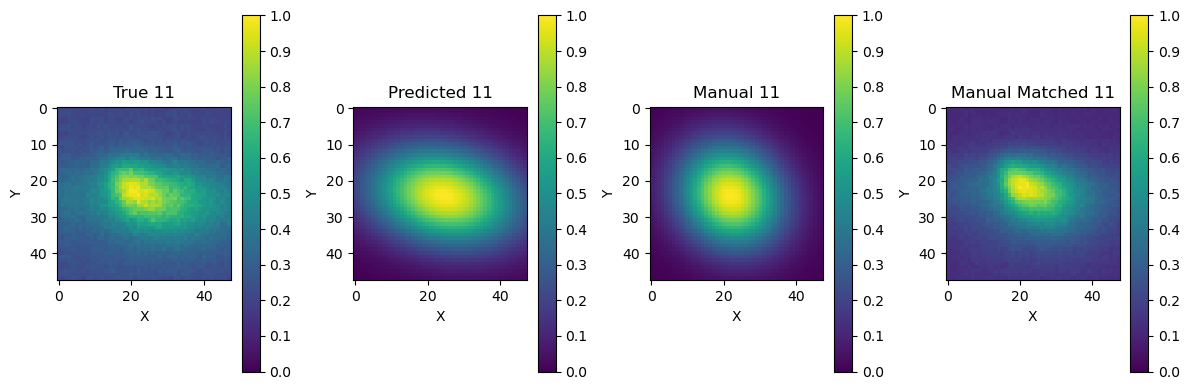

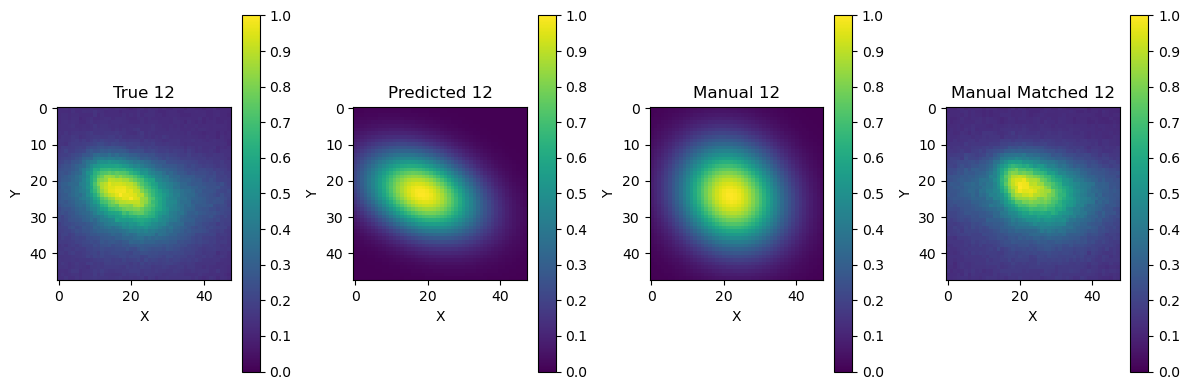

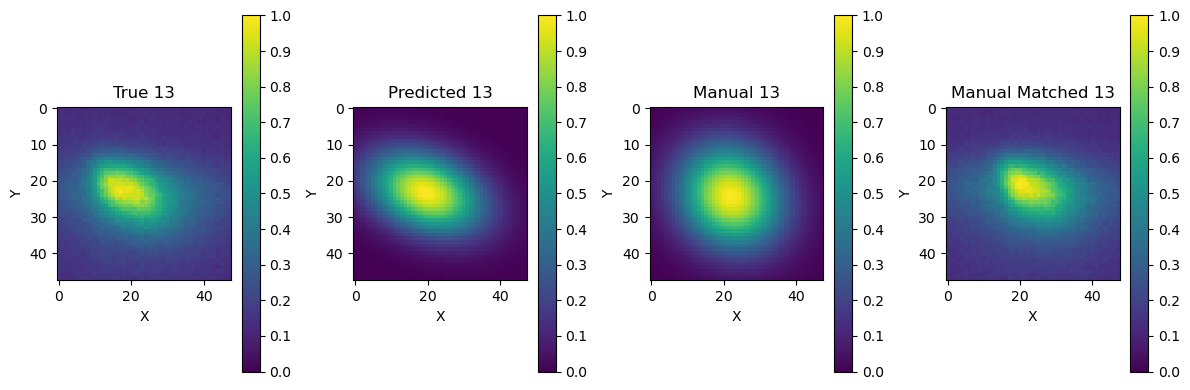

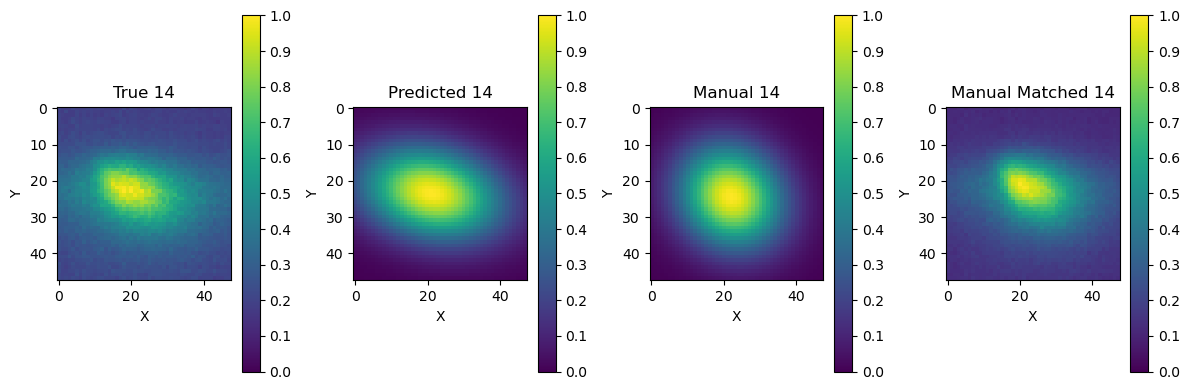

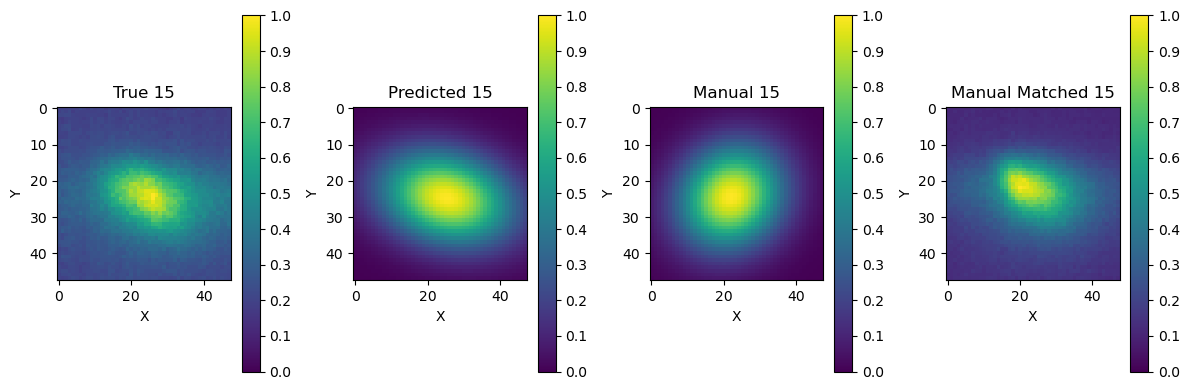

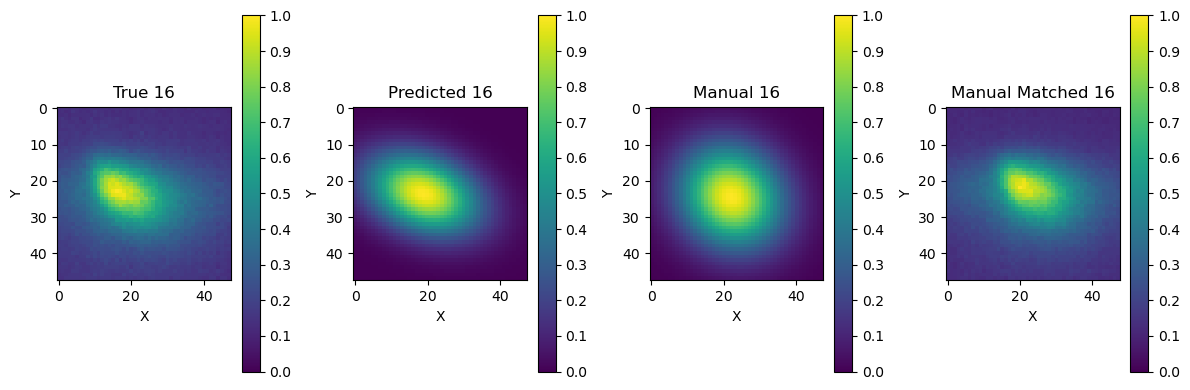

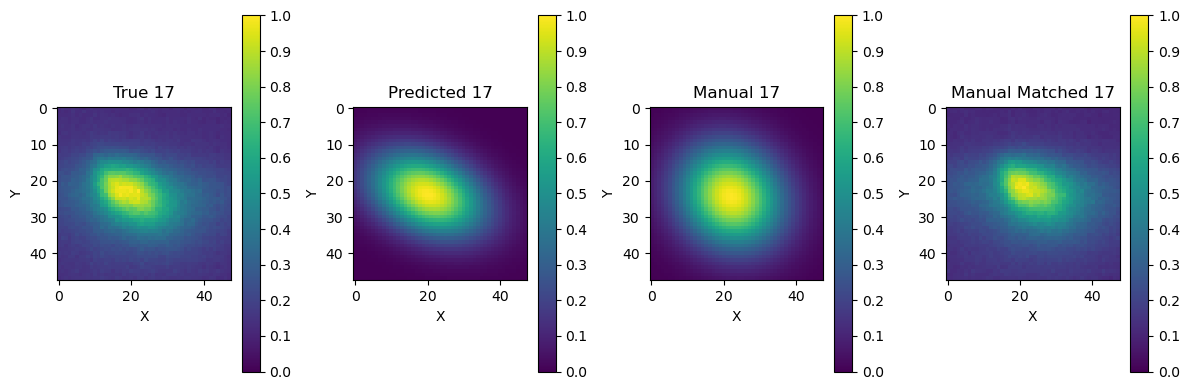

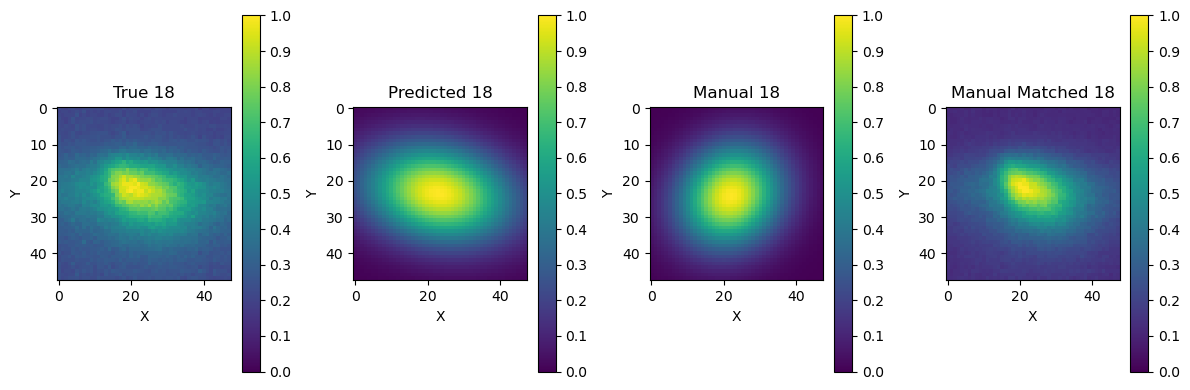

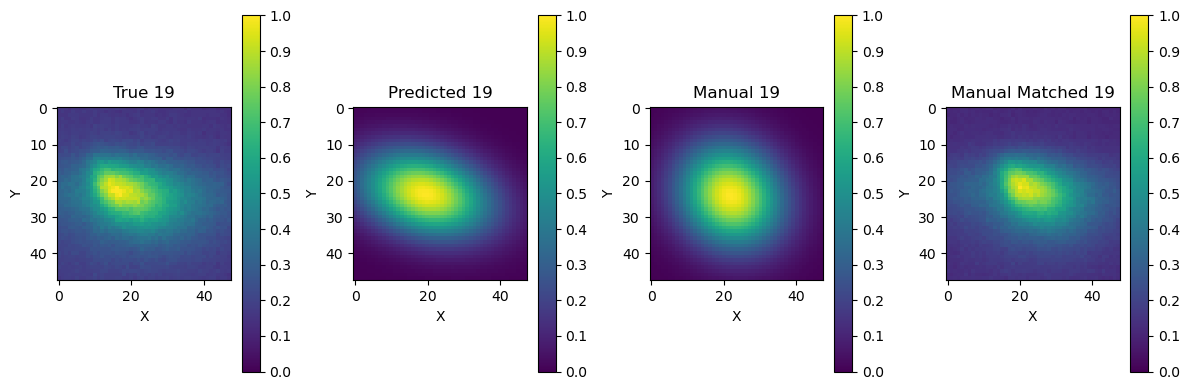

In [177]:

import matplotlib.pyplot as plt

for i in range(20):
    fig, axs = plt.subplots(1, 4, figsize=(12, 4))

    # Plot true image
    im0 = axs[0].imshow(data[i,0])
    im0.set_clim(0,1.0)
    axs[0].set_title(f'True {i}')
    axs[0].set_xlabel('X')
    axs[0].set_ylabel('Y')
    fig.colorbar(im0, ax=axs[0],ticks=np.arange(0, 1.1, 0.1))

    # Plot predicted image
    im1 = axs[1].imshow(outputs[i, 0].detach().cpu().numpy().squeeze())
    im1.set_clim(0,1.0)
    axs[1].set_title(f'Predicted {i}')
    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Y')
    fig.colorbar(im1, ax=axs[1],ticks=np.arange(0, 1.1, 0.1))

 
    im2 = axs[2].imshow(manual_im[i])
    im2.set_clim(0,1.0)
    axs[2].set_title(f'Manual {i}')
    axs[2].set_xlabel('X')
    axs[2].set_ylabel('Y')
    fig.colorbar(im2, ax=axs[2],ticks=np.arange(0, 1.1, 0.1))
    
    im3 = axs[3].imshow(manual_im_matched[i])
    im3.set_clim(0,1.0)
    axs[3].set_title(f'Manual Matched {i}')
    axs[3].set_xlabel('X')
    axs[3].set_ylabel('Y')
    fig.colorbar(im3, ax=axs[3],ticks=np.arange(0, 1.1, 0.1))

    # Adjust the layout and spacing
    plt.tight_layout()

    # Save the figure
    # plt.savefig(f'OutputData/images_{i}.png')

    # Display the figure
    plt.show()



In [166]:
torch.save(net.state_dict(), 'PytorchLeNet_4848_done.pt')
#Saves the most recent model

In [62]:
#Model analyzer


model = LeNet5(GaussianGenerator((48,48)).float(),5)  # Replace num_classes with the appropriate number for your task

# Count the number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

for name, param in model.named_parameters():
    print(f"Layer: {name}, Shape: {param.shape}, Parameters: {param.numel()}")

Total number of parameters: 22239
Layer: layer1.0.weight, Shape: torch.Size([6, 1, 5, 5]), Parameters: 150
Layer: layer1.0.bias, Shape: torch.Size([6]), Parameters: 6
Layer: layer1.1.weight, Shape: torch.Size([6]), Parameters: 6
Layer: layer1.1.bias, Shape: torch.Size([6]), Parameters: 6
Layer: layer2.0.weight, Shape: torch.Size([16, 6, 5, 5]), Parameters: 2400
Layer: layer2.0.bias, Shape: torch.Size([16]), Parameters: 16
Layer: layer2.1.weight, Shape: torch.Size([16]), Parameters: 16
Layer: layer2.1.bias, Shape: torch.Size([16]), Parameters: 16
Layer: fc.weight, Shape: torch.Size([98, 144]), Parameters: 14112
Layer: fc.bias, Shape: torch.Size([98]), Parameters: 98
Layer: fc1.weight, Shape: torch.Size([52, 98]), Parameters: 5096
Layer: fc1.bias, Shape: torch.Size([52]), Parameters: 52
Layer: fc2.weight, Shape: torch.Size([5, 52]), Parameters: 260
Layer: fc2.bias, Shape: torch.Size([5]), Parameters: 5


In [1]:
#testing pytorch model inference
model_pytorch=LeNet5_inference(5)
model_pytorch.load_state_dict(torch.load('PytorchLeNet_4848.pt'))
model_pytorch.eval() 


NameError: name 'LeNet5_inference' is not defined

In [40]:
path = '/home/ferroelectric/sean/RHEED_4848_test6.h5'

with h5py.File(path, 'r') as h5:
    img = h5['growth_1']['spot_2'][3]
    img= img/img.max()
img_tensor = torch.tensor(img).unsqueeze(0).unsqueeze(0)
print(img_tensor.shape)
with torch.no_grad():
    output_pytorch = model_pytorch(img_tensor)
print(output_pytorch)

torch.Size([1, 1, 48, 48])
tensor([[-4158.5146,    21.7672,  3202.0952,    11.8726,   -32.3630]])


(29, 48)


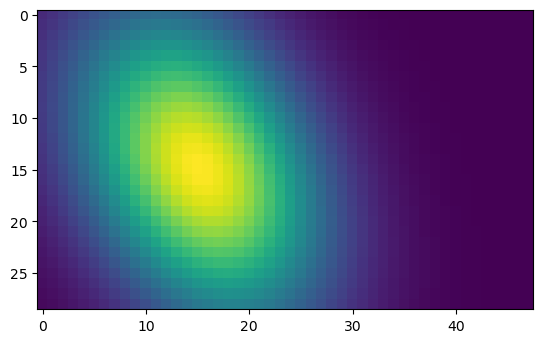

In [ ]:
#using gaussian generator with 5 inference parameters as input to compare.
import numpy as np
def gaussian(img_dim,params):
    params=np.array(params)
    mean_x, mean_y, cov_x, cov_y, theta = params
    
    x = np.arange(img_dim[1], dtype=np.float32)
    y = np.arange(img_dim[0], dtype=np.float32)
    x, y = np.meshgrid(x, y)

    x = np.expand_dims(x, axis=0)
    y = np.expand_dims(y, axis=0)
    
    

    x = np.repeat(x, 1, axis=0)
    y = np.repeat(y, 1, axis=0)

    rota_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    rota_matrix = np.reshape(rota_matrix, (1, 2, 2))

    xy = np.stack([x - mean_x, y - mean_y], axis=-1)
    xy = np.einsum('bijk,bkl->bijl', xy, rota_matrix)

    img = np.exp(-0.5 * (xy[:, :, :, 0]**2 / (cov_x**2) + xy[:, :, :, 1]**2 / (cov_y**2)))
    return img[0,:,:]
print(img.shape)
plt.imshow(gaussian((48,48),output_pytorch[0]))
# plt.imshow(img)
# plt.show()


In [ ]:
#using gaussian generator with 5 inference parameters as input to compare.
def gaussian(img_dim,params):
    params=np.array(params)
    print(params)
    mean_x, mean_y, cov_x, cov_y, theta = params
    
    x = np.arange(img_dim[1], dtype=np.float32)
    y = np.arange(img_dim[0], dtype=np.float32)
    x, y = np.meshgrid(x, y)

    x = np.expand_dims(x, axis=0)
    y = np.expand_dims(y, axis=0)

    x = np.repeat(x, 1, axis=0)
    y = np.repeat(y, 1, axis=0)

    rota_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    rota_matrix = np.reshape(rota_matrix, (1, 2, 2))

    xy = np.stack([x - mean_x, y - mean_y], axis=-1)
    xy = np.einsum('bijk,bkl->bijl', xy, rota_matrix)

    img = np.exp(-0.5 * (xy[:, :, :, 0]**2 / (cov_x**2) + xy[:, :, :, 1]**2 / (cov_y**2)))
    return img[0,:,:]

print(img.shape)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

im0 = axs[0].imshow(img)
im0.set_clim(0,1.0)
axs[0].set_title(f'True')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
fig.colorbar(im0, ax=axs[0],ticks=np.arange(0, 1.1, 0.1))


im1 = axs[1].imshow(gaussian((48,48),output_pytorch[0]))
im1.set_clim(0,1.0)
axs[1].set_title(f'Predicted')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')
fig.colorbar(im1, ax=axs[1],ticks=np.arange(0, 1.1, 0.1))

plt.tight_layout()


plt.show()


